In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Exercise 4

In [11]:
class GridWorld:
    def __init__(self, grid_size=4, max_steps=100):
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.num_actions = 4  # Up, Down, Left, Right
        self.actions = ['up', 'down', 'left', 'right']
        self.actions_map = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}
        self.terminal_states = [(0, 0), (grid_size - 1, grid_size - 1)]
        self.target_policy = np.ones((grid_size, grid_size, len(self.actions))) / len(self.actions)  
        self.behavior_policy =  np.ones((grid_size, grid_size, len(self.actions))) / len(self.actions)
        self.reset()

    def reset(self):
        self.state = (self.grid_size - 1, 0) 
        self.steps = 0
        return self.state

    def is_terminal(self, state):
        return state in self.terminal_states

    def step(self, state, action, evaluate=False):
        if not evaluate:
            self.steps += 1

        if state in self.terminal_states:
            return state, 0, True  
        
        if self.steps >= self.max_steps:
            return state, 0, True   

        x, y = state
        dx, dy = self.actions_map[action]
        new_x, new_y = x + dx, y + dy

        if 0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size:
            next_state = (new_x, new_y)
        else:
            next_state = (x, y) 

        reward = -1 
        done = next_state in self.terminal_states

        if not evaluate:
            self.state = next_state

        return next_state, reward, done

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        for terminal_state in self.terminal_states:
            grid[terminal_state] = -10  
        grid[self.state] = 1  
        print(grid)

    def reset(self):
        x = random.randint(0, self.grid_size - 1)
        y = random.randint(0, self.grid_size - 1)
        self.state = (x, y)
        self.steps = 0
        return self.state

    def generate_episode(self):  
        episode_data = []  
        self.reset() 
        done = False

        while not done:
            current_state = self.state
            action = np.random.choice(self.actions, p=self.behavior_policy[current_state])  
            next_state, reward, done = self.step(current_state, action)
            episode_data.append((current_state, action, reward))

        return episode_data

    def plot_policy(self, custom_title = None):
        X, Y = np.meshgrid(range(self.grid_size), range(self.grid_size))

        action_to_arrow = {'up': (0, -1), 'down': (0, 1), 'left': (-1, 0), 'right': (1, 0)}

        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if (i, j) in self.terminal_states:
                    plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='gray', alpha=0.5))
                    continue
                for action, prob in enumerate(self.target_policy[i, j]):
                    if prob > 0:
                        U, V = action_to_arrow[self.actions[action]]
                        plt.quiver(j+0.5, i+0.5, U, V, angles='xy', scale_units='xy', scale=2.0)

        plt.xlim([0, self.grid_size])
        plt.ylim([0, self.grid_size])
        plt.gca().invert_yaxis() 
        plt.grid()
        plt.xticks(range(self.grid_size))
        plt.yticks(range(self.grid_size))
        if custom_title is not None:
            plt.title(custom_title)
        else:
            plt.title(f' policy after value iteration: Steps = {self.steps}')
        plt.show()

[[-10.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  1.   0.   0. -10.]]
Action: left
State: (3, 0)
Reward: -1
Done: False

[[-10.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  1.   0.   0. -10.]]
Action: down
State: (3, 0)
Reward: -1
Done: False

[[-10.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  1.   0.   0. -10.]]
Action: left
State: (3, 0)
Reward: -1
Done: False

[[-10.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  1.   0.   0. -10.]]
Action: down
State: (3, 0)
Reward: -1
Done: False

[[-10.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  1.   0.   0. -10.]]
Action: left
State: (3, 0)
Reward: -1
Done: False

[[-10.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  1.   0.   0. -10.]]
Action: down
State: (3, 0)
Reward: -1
Done: False

[[-10.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  1.   0.   0. -10.]]
Action: right
State: (3, 1)
Reward: -1
Done

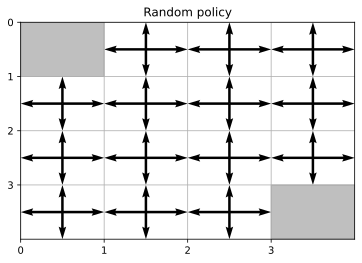

In [12]:
env = GridWorld()

for _ in range(10):
    env.render()
    action = np.random.choice(env.actions) 
    state, reward, done = env.step(env.state, action)
    print("Action:", action)
    print("State:", state)
    print("Reward:", reward)
    print("Done:", done)
    print()

    if done:
        break

env.plot_policy(custom_title="Random policy")

## Exercise 2

In [13]:
def off_policy_mc_control(env, episodes=50000, gamma=1.0):
  Q = np.zeros((env.grid_size, env.grid_size, env.num_actions)) - 100000 # Q-values
  C = np.zeros((env.grid_size, env.grid_size, env.num_actions)) # Counts

  for episode in range(episodes):
    episode_data = env.generate_episode()

    G = 0.0
    W = 1.0
   
    for state, action, reward in reversed(episode_data):
      action_index = env.actions.index(action)
      G = gamma * G + reward
      x, y = state
      #print(f'{state=}, {action_index=}, {action=}, {reward=}, {G=}, {W=}')
      C[x,y,action_index] += W 
      Q[x,y,action_index] += (W / C[x,y,action_index]) * (G - Q[x,y,action_index])

      env.target_policy[x,y] = np.eye(env.num_actions)[np.argmax(Q[x,y])]

      if action_index != np.argmax(env.target_policy[x,y]):
        break
      W = W * (1.0 / env.behavior_policy[x,y,action_index])

  return Q, env.target_policy 



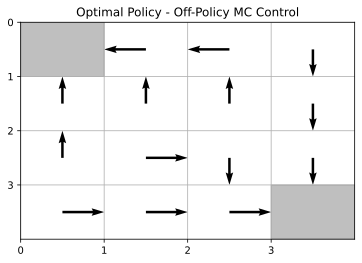

[[[ 0.          0.          0.          0.        ]
  [-1.99811143 -2.9994404  -0.99972194 -2.99946893]
  [-2.99918853 -3.99195661 -1.99948973 -3.99804042]
  [-3.99582342 -2.99869028 -2.99883689 -3.99717115]]

 [[-0.99972548 -2.99748627 -1.998751   -2.99914278]
  [-2.         -3.99285772 -2.00831899 -3.98905026]
  [-2.99610638 -2.99768772 -2.99917786 -2.997857  ]
  [-3.99693036 -1.99923877 -3.98576999 -2.9996224 ]]

 [[-1.999223   -3.995823   -2.99961583 -3.99509954]
  [-2.999422   -2.99776286 -2.99889832 -2.99705401]
  [-3.99972946 -1.99913681 -3.9962598  -1.99914664]
  [-2.99856836 -0.99963497 -3.04783513 -1.9989071 ]]

 [[-2.99816144 -3.99759799 -3.99490918 -2.99760629]
  [-3.99746818 -2.99798276 -3.99437843 -1.99886371]
  [-2.99829025 -1.99962777 -2.99899827 -0.99963249]
  [ 0.          0.          0.          0.        ]]]


In [14]:
# Example Usage
env = GridWorld()
Q, optimal_policy = off_policy_mc_control(env)
env.policy = optimal_policy
env.plot_policy("Optimal Policy - Off-Policy MC Control") 

print(Q)

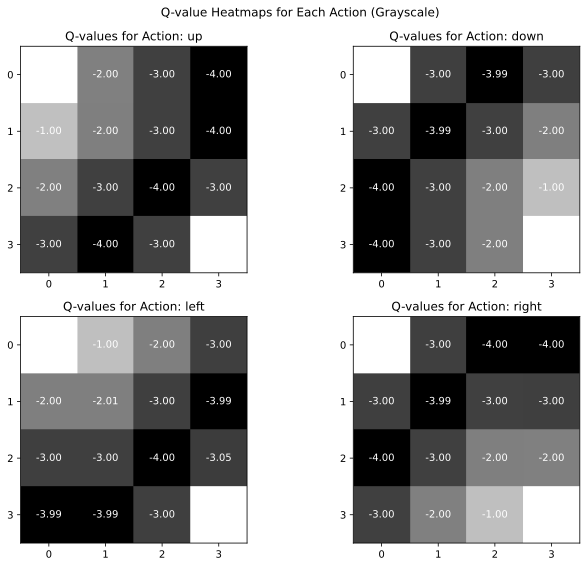

In [17]:
def plot_q_values(env, Q):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.flatten()  

    for i, action in enumerate(env.actions):
        heatmap_data = Q[:, :, i] 
        vmin = heatmap_data.min()
        vmax = heatmap_data.max()
        im = axs[i].imshow(heatmap_data, cmap='gray', vmin=vmin, vmax=vmax)  # Grayscale

        # Add text annotations
        for row in range(env.grid_size):
            for col in range(env.grid_size):
                text = axs[i].text(col, row, f"{heatmap_data[row, col]:.2f}",
                                   ha="center", va="center", color="w") 

        axs[i].set_title(f"Q-values for Action: {action}")
        axs[i].set_xticks(range(env.grid_size))
        axs[i].set_yticks(range(env.grid_size))

    plt.suptitle("Q-value Heatmaps for Each Action (Grayscale)")
    plt.tight_layout()
    plt.show()
plot_q_values(env, Q) 


## Exercise 4

In [3]:
class CliffWalkingEnv:
    def __init__(self, width=12, height=4):
        self.width = width
        self.height = height
        self.start_state = (3, 0)
        self.goal_state = (3, 11)
        self.cliff_states = [(3, 1), (3, 2), (3,3), (3,4), (3,5), (3,6), (3,7), (3,8), (3,9), (3, 10)]

        self.actions = ["UP", "RIGHT", "DOWN", "LEFT"]
        self.action_map = {
            "UP": (-1, 0),
            "DOWN": (1, 0),
            "LEFT": (0, -1),
            "RIGHT": (0, 1)
        }
        self.reset()

    def reset(self):
        self.current_state = self.start_state
        return self.current_state

    def step(self, action):
        delta_row, delta_col = self.action_map[action]
        next_row = min(max(self.current_state[0] + delta_row, 0), self.height - 1)
        next_col = min(max(self.current_state[1] + delta_col, 0), self.width - 1)
        next_state = (next_row, next_col)

        reward = -1
        done = False

        if next_state in self.cliff_states:
            reward = -100
            next_state = self.start_state

        if next_state == self.goal_state:
            done = True

        self.current_state = next_state
        return next_state, reward, done
    
    def choose_action(self, Q, state, epsilon):
        if random.random() < epsilon:
            action = random.choice(env.actions)
        else:
            action = env.actions[np.argmax(Q[state])]
        return action 

    def generate_episode(self, Q, epsilon, print_episode=False):
        """Generates an episode using an epsilon-greedy policy based on Q-values """
        states_visited = []
        state = env.reset()
        states_visited.append(state)
        done = False
        while not done:
            action = self.choose_action(Q, state, epsilon)
            next_state, reward, done = env.step(action)
            if print_episode:
                print(f'{action=}, {next_state=}, {reward=}, {done=}')
            states_visited.append(next_state)
            state = next_state

        return states_visited

    def plot_episode_path(self, states_visited):
        """Creates a simple plot of the gridworld and the agent's path with alpha values"""
        grid = np.ones((env.height, env.width))
        grid[env.start_state] = 1  
        grid[env.goal_state] = 2
        for state in env.cliff_states:
            grid[state] = -1 

        path_x = [state[1] for state in states_visited]
        path_y = [state[0] for state in states_visited]

        # Count state visits
        state_counts = {}
        for state in states_visited:
            state_counts[state] = state_counts.get(state, 0) + 1

        # Plot path (stays the same as before)
        plt.figure(figsize=(8, 6))
        plt.imshow(grid, cmap='gray', vmin=-2, vmax=3,)  # Changed colormap
        plt.plot(path_x, path_y, '-o', color='blue', alpha=0.8)  

        # Overlay state visit counts
        for state, count in state_counts.items():
            plt.text(state[1], state[0], str(count), ha='center', va='center', color='white') 

        plt.title('Cliff Walking Episode Path (with Visit Counts)')  # Updated title
        plt.xticks(range(env.width))
        plt.yticks(range(env.height))
        plt.show()


action='RIGHT', next_state=(3, 0), reward=-100, done=False
action='DOWN', next_state=(3, 0), reward=-1, done=False
action='DOWN', next_state=(3, 0), reward=-1, done=False
action='RIGHT', next_state=(3, 0), reward=-100, done=False
action='DOWN', next_state=(3, 0), reward=-1, done=False
action='RIGHT', next_state=(3, 0), reward=-100, done=False
action='LEFT', next_state=(3, 0), reward=-1, done=False
action='LEFT', next_state=(3, 0), reward=-1, done=False
action='UP', next_state=(2, 0), reward=-1, done=False
action='RIGHT', next_state=(2, 1), reward=-1, done=False
action='RIGHT', next_state=(2, 2), reward=-1, done=False
action='UP', next_state=(1, 2), reward=-1, done=False
action='UP', next_state=(0, 2), reward=-1, done=False
action='RIGHT', next_state=(0, 3), reward=-1, done=False
action='DOWN', next_state=(1, 3), reward=-1, done=False
action='DOWN', next_state=(2, 3), reward=-1, done=False
action='DOWN', next_state=(3, 0), reward=-100, done=False
action='LEFT', next_state=(3, 0), reward

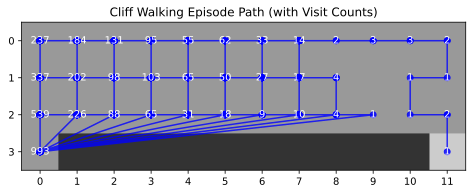

In [4]:
env = CliffWalkingEnv()

Q = np.zeros((env.height, env.width, len(env.actions)))

episode_path = env.generate_episode(Q, epsilon=1, print_episode=True)  # Use a smaller epsilon to exploit
env.plot_episode_path(episode_path) 

## Exercise 5

In [5]:
def sarsa(env, num_episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.height, env.width, len(env.actions)))

    for _ in range(num_episodes):
        state = env.reset()
        x, y = state
        action = env.choose_action(Q, state, epsilon)  
        done = False
        while not done:
            next_state, reward, done = env.step(action)
            next_action = env.choose_action(Q, next_state, epsilon)
            next_action_index = env.actions.index(next_action)
            action_index = env.actions.index(action)
            Q[state][action_index] += alpha * (reward + gamma * Q[next_state][next_action_index] - Q[state][action_index])

            state = next_state
            action = next_action

    return Q



In [6]:
def plot_q_values(env, Q):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.flatten()  

    for i, action in enumerate(env.actions):
        heatmap_data = Q[:, :, i] 
        vmin = heatmap_data.min()
        vmax = heatmap_data.max()
        im = axs[i].imshow(heatmap_data, cmap='gray', vmin=vmin, vmax=vmax)  # Grayscale

        # Add text annotations
        for row in range(env.height):
            for col in range(env.width):
                text = axs[i].text(col, row, f"{heatmap_data[row, col]:.2f}",
                                   ha="center", va="center", color="w") 

        axs[i].set_title(f"Q-values for Action: {action}")
        axs[i].set_xticks(range(env.width))
        axs[i].set_yticks(range(env.height))

    plt.suptitle("Q-value Heatmaps for Each Action (Grayscale)")
    plt.tight_layout()
    plt.show()

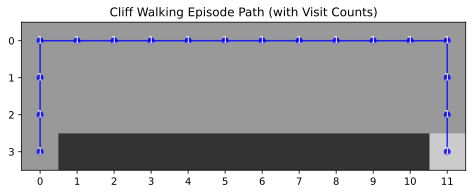

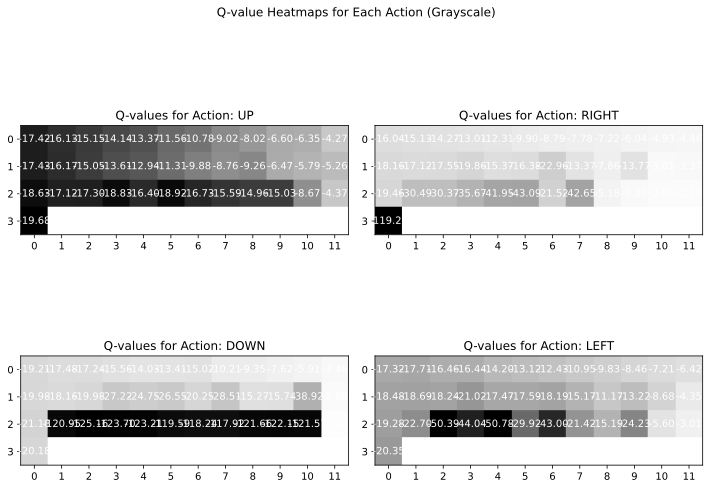

In [10]:
env = CliffWalkingEnv()
Q = sarsa(env, num_episodes=50000, alpha=0.3, gamma=1, epsilon=0.1)
episode_path = env.generate_episode(Q, epsilon=0)
env.plot_episode_path(episode_path)
# Plot Q-values
plot_q_values(env, Q)



## Exercise 5

In [16]:
def q_learning(env, num_episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.height, env.width, len(env.actions)))  

    for _ in range(num_episodes):
        state = env.reset()
        done = False
        while not done:  # Episode loop
            action = env.choose_action(Q, state, epsilon) 
            action_index = env.actions.index(action)
            next_state, reward, done = env.step(action)

            Q[state][action_index] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action_index]) 

            state = next_state 

    return Q

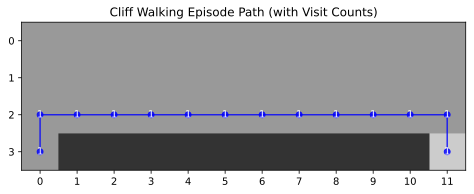

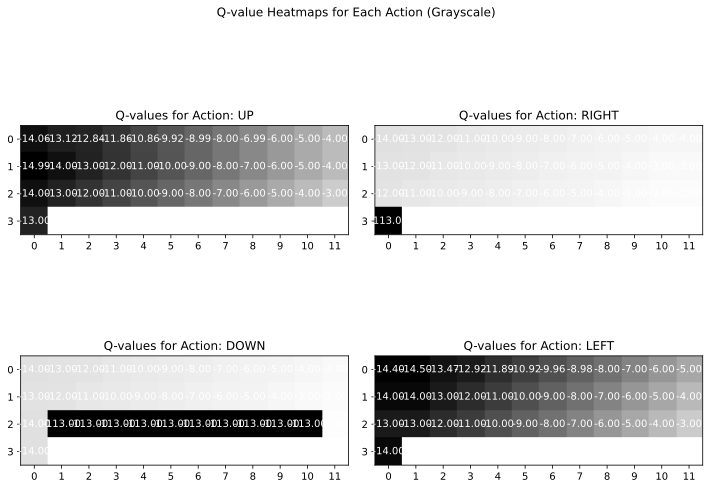

In [17]:

Q = q_learning(env, num_episodes=50000, alpha=0.3, gamma=1, epsilon=0.1)
episode_path = env.generate_episode(Q, epsilon=0)
env.plot_episode_path(episode_path)
plot_q_values(env, Q)